In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver
import pandas as pd
from time import sleep 
import scrapy
import random
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import time
from pandas import ExcelWriter
import xlsxwriter
import openpyxl
from openpyxl import workbook

In [2]:
# Instalamos en CONDA " pyLDAvis.gensim install conda " y " pyldavis install conda "

import pandas as pd
import os 
import re
from wordcloud import WordCloud

# Leemos los datos
papers = pd.read_excel('DatosInvestigacion-CargaCompleta.xlsx')
# Imprimimos los datos
papers.head()

,ID,TITULO,MES,AÑO,AUTORES,REVISTA,CITACIONES,REFERENCIAS
0,1,Security modelling and assessment of modern ne...,Dec15,2019,"Enoch, SY; Hong, JB and Kim, DS",JOURNAL OF NETWORK AND COMPUTER APPLICATIONS,5,52
1,2,Formalization of security patterns as a means ...,Feb,2015,"Varela-Vaca, AJ and Gasca, RM",LOGIC JOURNAL OF THE IGPL,5,32
2,3,Catalytic Decomposition of N2O over Co-Ti Oxid...,Jun21,2016,"Zhang, C; Zhang, ZP; (...); Zhu, YJ",CHEMCATCHEM,26,56
3,4,Security of electronic personal health informa...,Mar4,2022,"Chuma, KG and Ngoepe, M",INFORMATION SECURITY JOURNAL,1,59
4,5,Reversible Fluorescence Switching of Metal-Org...,Apr24,2020,"Venkateswarlu, S; Reddy, AS; (...); Yoon, MY",ACS APPLIED NANO MATERIALS,23,41


In [3]:
# Eliminamos las columnas
papers = papers.drop(columns=['ID', 'MES', 'AÑO', 'AUTORES', 'CITACIONES', 'REFERENCIAS'], axis=1).sample(100)
# Imprimimos
papers.head()

,TITULO,REVISTA
550,Electrochemical oxidation of trace organic con...,WATER RESEARCH
29,Reconviction and revocation rates in Flanders ...,INTERNATIONAL JOURNAL OF LAW AND PSYCHIATRY
686,"Effect of laser power on defect, texture, and ...",MATERIALS & DESIGN
253,On the model uncertainties in Bayesian source ...,GEOSCIENTIFIC MODEL DEVELOPMENT
242,Comparative study of precise measurements of n...,SCIENTIFIC REPORTS


In [4]:
# Quitar 
papers['TITULO_processed'] = \
papers['TITULO'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convertir los títulos a minúsculas 
papers['TITULO_processed'] = \
papers['TITULO'].map(lambda x: x.lower())
# Imprime las primeras filas de papeles 
papers['TITULO_processed'].head()



550    electrochemical oxidation of trace organic con...
29     reconviction and revocation rates in flanders ...
686    effect of laser power on defect, texture, and ...
253    on the model uncertainties in bayesian source ...
242    comparative study of precise measurements of n...
Name: TITULO_processed, dtype: object

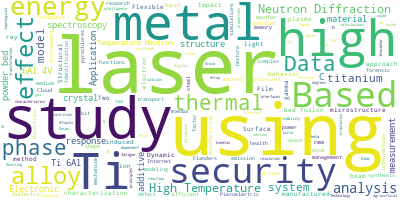

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['TITULO'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [6]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = papers.TITULO.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['electrochemical', 'oxidation', 'trace', 'organic', 'contaminants', 'reverse', 'osmosis', 'concentrate', 'using', 'ruo', 'iro', 'coated', 'titanium', 'anodes']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [8]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.012*"synthesis" + 0.012*"laser" + 0.012*"di" + 0.012*"defect" + '
  '0.012*"mixed" + 0.006*"assisted" + 0.006*"hafnium" + 0.006*"alkoxides" + '
  '0.006*"leds" + 0.006*"ti"'),
 (1,
  '0.025*"ti" + 0.018*"using" + 0.017*"study" + 0.013*"alc" + '
  '0.013*"temperature" + 0.009*"analysis" + 0.009*"diffraction" + '
  '0.009*"neutron" + 0.009*"nutrition" + 0.009*"structures"'),
 (2,
  '0.013*"co" + 0.013*"metal" + 0.013*"decay" + 0.013*"zirconium" + '
  '0.013*"data" + 0.012*"model" + 0.007*"chloride" + 0.007*"yields" + '
  '0.007*"zrcl" + 0.007*"thermal"'),
 (3,
  '0.014*"high" + 0.011*"laser" + 0.009*"temperature" + 0.009*"two" + '
  '0.008*"ti" + 0.008*"study" + 0.008*"ion" + 0.007*"tio" + 0.007*"resistant" '
  '+ 0.005*"neutron"'),
 (4,
  '0.013*"approach" + 0.013*"glow" + 0.013*"identification" + 0.011*"ray" + '
  '0.009*"spectroscopy" + 0.009*"gamma" + 0.008*"ti" + 0.007*"using" + '
  '0.007*"security" + 0.007*"dose"'),
 (5,
  '0.018*"ti" + 0.015*"laser" + 0.012*"induced" + 

In [10]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./USS-DMDB-Taller2'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './USS-DMDB-Taller2'+ str(num_topics) +'.html')

LDAvis_prepared

c:\Users\Admn\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.051409 -0.143801       1        1  15.277601
7      0.159167 -0.072316       2        1  13.676010
1     -0.116050  0.030076       3        1  13.665264
9     -0.078279 -0.050451       4        1   9.544014
0      0.020636  0.055659       5        1   9.007581
8      0.008204  0.016578       6        1   8.638884
2      0.040612  0.053702       7        1   8.158691
4     -0.007030  0.059146       8        1   7.596549
5      0.016343  0.024306       9        1   7.398415
6      0.007807  0.027102      10        1   7.036991, topic_info=              Term       Freq      Total Category  logprob  loglift
212           high   7.000000   7.000000  Default  30.0000  30.0000
25           laser   7.000000   7.000000  Default  29.0000  29.0000
151             ti  10.000000  10.000000  Default  28.0000  28.0000
469          phase   3.000000   3.000000  Default  27.0000  27.0000
62           study   4.000000   4.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
118          films   0.541805   1.567565  Topic10  -4.9287   1.5916
315     resolution   0.541804   1.616856  Topic10  -4.9287   1.5607
85        internet   0.541804   1.567552  Topic10  -4.9287   1.5916
217        thermal   0.541803   3.367973  Topic10  -4.9287   0.8268
122  piezoelectric   0.541800   1.567571  Topic10  -4.9287   1.5916

[475 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
392       6  0.897633    ablated
401       1  0.785038   ablation
144       1  0.343408   additive
144       2  0.343408   additive
144       6  0.343408   additive
...     ...       ...        ...
433       7  0.905262     yields
536       7  0.607829  zirconium
545       3  0.597781         zr
545      10  0.597781         zr
537       7  0.905262       zrcl

[529 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 2, 10, 1, 9, 3, 5, 6, 7])